# Degenerate Diffusion Simulation (dx=3, dy=2, r=3)

このノートブックでは、SymPy でモデルを構築し `DegenerateDiffusionProcess` を用いて JAX ベースのシミュレーションと可視化を行います。

## 1. Sympyシンボルとモデル式の定義

対象とするモデルは次の連立 SDE で与えられます。

$$
\begin{aligned}
dX_t &= \bigl(-\operatorname{diag}(\alpha) X_t + B Y_t\bigr)\, dt + \operatorname{diag}(\sigma)\, dW_t,\\
dY_t &= \bigl(G X_t - \delta Y_t + s\bigr)\, dt.
\end{aligned}
$$

ここで $X_t \in \mathbb{R}^3$, $Y_t \in \mathbb{R}^2$, $W_t$ は 3 次元の独立ブラウン運動です。

各項は次のように具体的にパラメータへ依存します。

$$
A(x, y; \theta_2) = -\begin{pmatrix}
\alpha_1 & 0 & 0\\
0 & \alpha_2 & 0\\
0 & 0 & \alpha_3
\end{pmatrix} x + \begin{pmatrix}
\beta_{11} & \beta_{12}\\
\beta_{21} & \beta_{22}\\
\beta_{31} & \beta_{32}
\end{pmatrix} y,
$$

$$
B(\theta_1) = \operatorname{diag}(\sigma_1, \sigma_2, \sigma_3), \qquad H(x, y; \theta_3) = \begin{pmatrix}
\gamma_{11} & \gamma_{12} & \gamma_{13}\\
\gamma_{21} & \gamma_{22} & \gamma_{23}
\end{pmatrix} x - \delta y + \begin{pmatrix}s_1\\ s_2\end{pmatrix}.
$$

以下では SymPy を用いて漂移項 `A`、拡散項 `B`、観測項 `H` を行列表現します。

In [1]:
import sympy as sp

# State and observation symbols
x_symbols = sp.symbols("x_0:3")
y_symbols = sp.symbols("y_0:2")
x_sym = sp.Array(x_symbols)
y_sym = sp.Array(y_symbols)

# Parameter symbols
sigma_symbols = sp.symbols("sigma_1 sigma_2 sigma_3")
alpha_symbols = sp.symbols("alpha_1 alpha_2 alpha_3")
beta_symbols = sp.symbols("beta_11 beta_12 beta_21 beta_22 beta_31 beta_32")
gamma_symbols = sp.symbols("gamma_11 gamma_12 gamma_13 gamma_21 gamma_22 gamma_23")
delta_sym = sp.symbols("delta")
s_symbols = sp.symbols("s_1 s_2")

# Construct matrices for drift, diffusion, and observation equations
Beta_matrix = sp.Matrix(
    [
        [beta_symbols[0], beta_symbols[1]],
        [beta_symbols[2], beta_symbols[3]],
        [beta_symbols[4], beta_symbols[5]],
    ]
)
diag_alpha = sp.diag(*alpha_symbols)
G_matrix = sp.Matrix(
    [
        [gamma_symbols[0], gamma_symbols[1], gamma_symbols[2]],
        [gamma_symbols[3], gamma_symbols[4], gamma_symbols[5]],
    ]
)
I2 = sp.eye(2)

drift_vec = -diag_alpha * sp.Matrix(x_sym) + Beta_matrix * sp.Matrix(y_sym)
obs_vec = G_matrix * sp.Matrix(x_sym) - delta_sym * I2 * sp.Matrix(y_sym) + sp.Matrix(s_symbols)

A_expr = sp.Array([drift_vec[i, 0] for i in range(3)])
B_expr = sp.Array(sp.diag(*sigma_symbols))
H_expr = sp.Array([obs_vec[i, 0] for i in range(2)])

theta1_sym = sp.Array(sigma_symbols)
theta2_sym = sp.Array((*alpha_symbols, *beta_symbols))
theta3_sym = sp.Array((*gamma_symbols, delta_sym, *s_symbols))

A_expr, B_expr, H_expr

([-alpha_1*x_0 + beta_11*y_0 + beta_12*y_1, -alpha_2*x_1 + beta_21*y_0 + beta_22*y_1, -alpha_3*x_2 + beta_31*y_0 + beta_32*y_1],
 [[sigma_1, 0, 0], [0, sigma_2, 0], [0, 0, sigma_3]],
 [-delta*y_0 + gamma_11*x_0 + gamma_12*x_1 + gamma_13*x_2 + s_1, -delta*y_1 + gamma_21*x_0 + gamma_22*x_1 + gamma_23*x_2 + s_2])

## 2. DegenerateDiffusionProcessインスタンス生成

記号式を用いて `DegenerateDiffusionProcess` を初期化し、JAX 互換の関数を生成します。

In [2]:
from degenerate_diffusion.processes.degenerate_diffusion_process import DegenerateDiffusionProcess

process = DegenerateDiffusionProcess(
    x=x_sym,
    y=y_sym,
    theta_1=theta1_sym,
    theta_2=theta2_sym,
    theta_3=theta3_sym,
    A=A_expr,
    B=B_expr,
    H=H_expr,
)

process

DegenerateDiffusionProcess(x=[x_0, x_1, x_2], y=[y_0, y_1], theta_1=[sigma_1, sigma_2, sigma_3], theta_2=[alpha_1, alpha_2, alpha_3, beta_11, beta_12, beta_21, beta_22, beta_31, beta_32], theta_3=[gamma_11, gamma_12, gamma_13, gamma_21, gamma_22, gamma_23, delta, s_1, s_2], A=SymbolicArtifact(expr=[-alpha_1*x_0 + beta_11*y_0 + beta_12*y_1, -alpha_2*x_1 + beta_21*y_0 + beta_22*y_1, -alpha_3*x_2 + beta_31*y_0 + beta_32*y_1], func=<function _lambdifygenerated at 0x131e80180>), B=SymbolicArtifact(expr=[[sigma_1, 0, 0], [0, sigma_2, 0], [0, 0, sigma_3]], func=<function _lambdifygenerated at 0x131e81120>), H=SymbolicArtifact(expr=[-delta*y_0 + gamma_11*x_0 + gamma_12*x_1 + gamma_13*x_2 + s_1, -delta*y_1 + gamma_21*x_0 + gamma_22*x_1 + gamma_23*x_2 + s_2], func=<function _lambdifygenerated at 0x131e4bec0>))

## 3. 真のパラメータ設定と初期状態

推奨パラメータを JAX 配列として設定し、初期値とシミュレーション刻みを定義します。

In [3]:
import jax
import jax.numpy as jnp
import numpy as np

sigma_true = jnp.array([0.5, 0.6, 0.7], dtype=jnp.float32)
alpha_true = jnp.array([1.0, 2.0, 3.0], dtype=jnp.float32)
beta_true = jnp.array([0.0, 1.0, 1.0, 0.0, 0.0, 1.0], dtype=jnp.float32)
theta2_true = jnp.concatenate([alpha_true, beta_true])

gamma_true = jnp.array([1.0, 0.0, 1.0, 0.0, 1.0, 1.0], dtype=jnp.float32)
delta_true = jnp.array([1.0], dtype=jnp.float32)
s_true = jnp.array([0.0, 0.0], dtype=jnp.float32)
theta3_true = jnp.concatenate([gamma_true, delta_true, s_true])

true_theta = (sigma_true, theta2_true, theta3_true)

dt = 0.001
h = 0.05
t_max = 100.0
burn_out = 0.5
seed = 123

x0 = jnp.zeros((3,), dtype=jnp.float32)
y0 = jnp.zeros((2,), dtype=jnp.float32)

{
    "theta_1": sigma_true,
    "theta_2": theta2_true,
    "theta_3": theta3_true,
    "dt": dt,
    "h": h,
    "t_max": t_max,
    "burn_out": burn_out,
}

{'theta_1': Array([0.5, 0.6, 0.7], dtype=float32),
 'theta_2': Array([1., 2., 3., 0., 1., 1., 0., 0., 1.], dtype=float32),
 'theta_3': Array([1., 0., 1., 0., 1., 1., 1., 0., 0.], dtype=float32),
 'dt': 0.001,
 'h': 0.05,
 't_max': 100.0,
 'burn_out': 0.5}

## 4. シミュレーション実行 (JAX)

`simulate` を呼び出し、Euler-Maruyama による離散過程を生成します。

In [4]:
x_series, y_series = process.simulate(
    true_theta=true_theta,
    t_max=t_max,
    h=h,
    burn_out=burn_out,
    seed=seed,
    x0=x0,
    y0=y0,
    dt=dt,
)

x_series_np = np.asarray(x_series)
y_series_np = np.asarray(y_series)
time_axis = np.arange(x_series_np.shape[0]) * h

x_series_np.shape, y_series_np.shape

((2001, 3), (2001, 2))

## 5. 結果の可視化と派生行列の確認

状態・観測系列を可視化し、$C = BB^\top$ と $V = G C G^\top$ の固有値から正定値性を確認します。

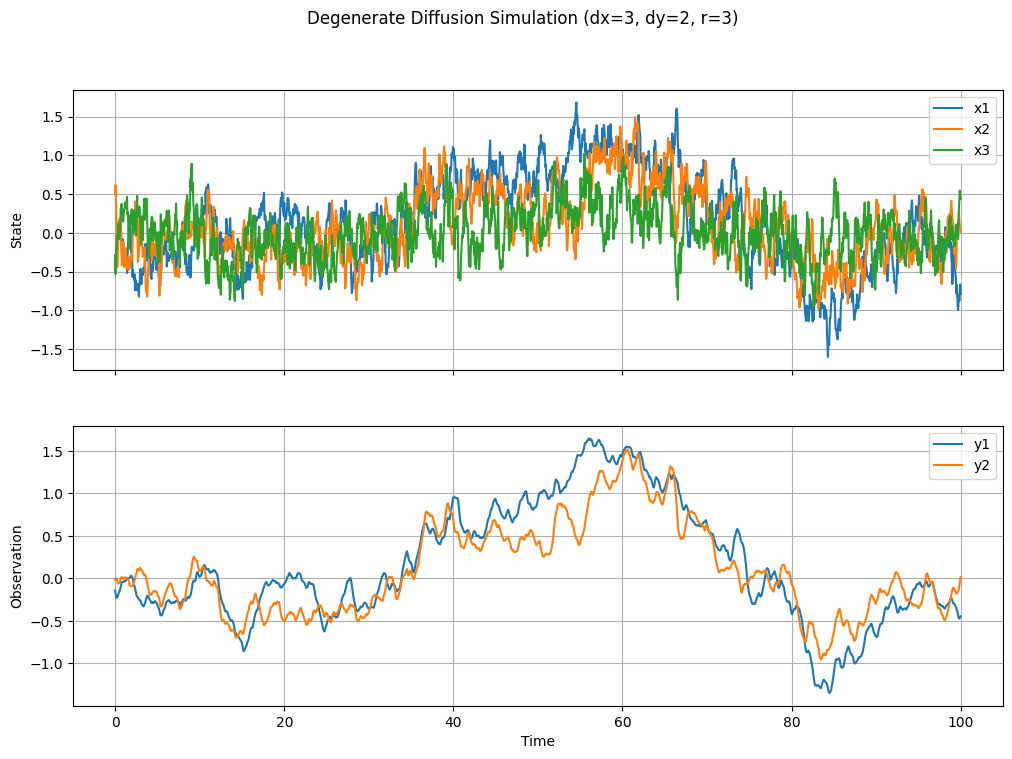

{'C': array([[0.25      , 0.        , 0.        ],
        [0.        , 0.36      , 0.        ],
        [0.        , 0.        , 0.48999998]], dtype=float32),
 'V': array([[0.74      , 0.48999998],
        [0.48999998, 0.85      ]], dtype=float32),
 'eig(V)': array([0.30192298, 1.2880771 ], dtype=float32)}

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for idx in range(x_series_np.shape[1]):
    axes[0].plot(time_axis, x_series_np[:, idx], label=f"x{idx + 1}")
axes[0].set_ylabel("State")
axes[0].grid(True)
axes[0].legend()

for idx in range(y_series_np.shape[1]):
    axes[1].plot(time_axis, y_series_np[:, idx], label=f"y{idx + 1}")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Observation")
axes[1].grid(True)
axes[1].legend()

fig.suptitle("Degenerate Diffusion Simulation (dx=3, dy=2, r=3)")
plt.show()

C = jnp.diag(sigma_true**2)
G_true = gamma_true.reshape(2, 3)
V = G_true @ C @ G_true.T
eigenvalues = jnp.linalg.eigvalsh(V)

{
    "C": np.asarray(C),
    "V": np.asarray(V),
    "eig(V)": np.asarray(eigenvalues),
}